In [ ]:
"""
Next steps:
    0. distinguish different kinds of errors and decide what their effects on the score will be     
        1. effect of number of test cases -> plot num of test cases vs correlation
    2. test GPT-4
    3. run on APPS
    5. test on token optimization to optimize costs
    17. what if the code uses uninstalled modules? what is the backend for the website?    
        
    # FATHY -> website
        8. should add a user flag to determine whether the output is deterministic or not to help with exact match output strings and lists
        9. should add a user flag to config timeout
    10. run old experiments on distance correlation
        13. should add a box to enter the API key; which API key and how owuld we ensure security for the user's info?
        business model could be a subscription fee for the API key

    # FEKRY & RAFIK
    19. check sample 109 and why did it decrease from 100 to 95 in similarity

    # AMR
    



Tips:
    - in real time, parse the entry point from the base response to make sure no errors happen, or maybe parse from each reponse to take less time
    - input and output for ui design
    - Dr. Seif's feedback


    try code generation temps: 0.1, 0.3, 0.5, 0.7, 1
    
    
    
    
    
    https://github.com/openai/evals
"""

Tasks:
    Fekry & Rafik
Ask Rafik if he utilized GPT to optimize the prompt of generating test cases
Check Error pipe and add a token, representing any error for the result of the check program
Optimize the prompt of generating test cases: “Do not include any comments”
Check STd.out because it could lead to a problem if the code includes more than one print statement
Check other ways to evaluate a testcase with a code other than the printing method
Utilize Amer’s function of removing Comments from all generated codes
generating json files for LLM outputs
look at the low pass rate samples and see why they are low; low red
try different temps

    Amer:
OpenAI evaluation: exact match, contains, partial match, fuzzy match: https://github.com/openai/evals/blob/main/docs/eval-templates.md 
prompt optimization
invistigate deepsim

    Amr:
Parallelize the execution process

    Fathy:
run old experiments on distance correlation
Website: a user flag to determine whether the output is deterministic or not to help with exact match output strings and lists
         a user flag to config timeout
         a user box to enter his OpenAI API key, or change community deployment to business model


    Tolba:
Drafting the paper

AT THE END:
do the correlation scatter plot that Rafea mentioned
criticize the model output by using two agents like GANs: generating and critique https://arxiv.org/abs/2310.13855 

ALL:
We need to think about the scope: in terms of: 
1. The functions with no output, 
2. Different languages. 
3. DIfferent LLMs  
4. Difficulty levels of functions 
5. Input type

Problem of “at most” => False Positive because GPT did not understand the logic | Will be solved 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import argparse
import csv
import json
import pprint
import subprocess
import dcor

# AZURE API

In [88]:
from openai import AzureOpenAI
# gets the API Key from environment variable AZURE_OPENAI_API_KEY
client = AzureOpenAI(
    azure_endpoint="https://team5-chatgpt-4-api.openai.azure.com/",
    api_version = "2023-05-15",  # Use the latest available version
    api_key = "9423fcf02a494b5cbe440c6971903ba7",
)

In [89]:
#read the dataset from the jsonl file
df = pd.read_json('human-eval-modified-with-tests.jsonl', lines=True)

df.head()

,task_id,prompt,entry_point,canonical_solution,test,GPT4_10_generated_tests
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,has_close_elements,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...","has_close_elements([], 1.0)#lak#has_close_elem..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups(((()))')#lak#separate_pa...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number(0.75)#lak#truncate_number(10.0...
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,below_zero,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","below_zero([100, -50, -30])#lak#below_zero([-1..."
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean_absolute_deviation,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5..."


# Generating the test cases as function calls with test inputs

In [58]:
# chat completion
responses = pd.DataFrame(columns=['taskID', 'prompt', 'entry_point', 'response'])

taskID = df['task_id'].tolist()
prompts = df['prompt'].tolist()
entry_points = df['entry_point'].tolist()

l = len(df)

tests_num= 10

for i in range(l):
    ID = taskID[i]
    problem_statement = prompts[i]
    entry_point = entry_points[i]
        
    response = client.chat.completions.create(
        model="gpt4-api",  # The name you used when deploying the model
        messages=[
            {"role": "system", "content": "You are a helpful Python programming assistant. Your objective is to create test inputs for the given problem."},
            {"role": "user", "content": f"""For the given problem statement, create test inputs. The format of the input is a list of inputs.
                                        The problem statement is: {problem_statement}.
                                        The entry point is: {entry_point},
                                        The input list is {tests_num} inputs representing {tests_num} test cases. Cover basic test cases and edge cases.
                                        Return only the function calls with each of the test cases, each in a separate line, without any other text."""},
        ]
    )

    response_text = response.choices[0].message.content
    temp_df = pd.DataFrame([[ID, problem_statement, entry_point, response_text]], columns=['taskID', 'prompt', 'entry_point', 'response'])
    responses = pd.concat([responses, temp_df], ignore_index=True)

In [8]:
prompts = df['prompt'].tolist()
entry_points = df['entry_point'].tolist()
problem_statement = prompts[0]
entry_point = entry_points[0]
print

response = client.chat.completions.create(
        model="gpt4-api",  # The name you used when deploying the model
        messages=[
            {"role": "system", "content": "You are a helpful Python programming assistant. Your objective is to create test inputs for the given problem."},
            {"role": "user", "content": f"""For the given problem statement, create test inputs. The format of the input is a list of inputs.
                                        The problem statement is: {problem_statement}.
                                        The entry point is: {entry_point},
                                        The input list is {5} inputs representing {5} test cases. Cover basic test cases and edge cases.
                                        Return only the function calls with each of the test cases, each in a separate line, without any other text."""},
        ]
    )
response_text = response.choices[0].message.content
print(response_text)

has_close_elements([1.0, 2.0, 3.0], 0.5)
has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
has_close_elements([-10.5, -10.1, -9.8], 0.4)
has_close_elements([0.0], 1.0)
has_close_elements([1.23456789, 1.23456780, 2.3456789], 0.0000001)


In [9]:
print(problem_statement)

from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """



# Parsing the test cases as function calls

In [4]:
def remove_outside_quotes(text):
    # Match quotes outside of parentheses and replace them
    result = re.sub(r'\"(?![^()]*\))', '', text)
    result = re.sub(r"\'(?![^()]*\))", '', result)
    return result


tests_num = 10


# create a dataframe to store the inputs and to change dynamically (the columns) based on the number of tests
cols = ['task_id'] + [f'GPT4_10_generated_tests']


All = pd.DataFrame(columns=cols)


for row in responses.iterrows():
    #parse the response to get the list of inputs
    inputs = row[1]['response'].split("\n")
    #remove any input that doesn't have the entry point
    inputs = [input for input in inputs if row[1]['entry_point'] in input]

    #remove the quotes from the inputs using the function defined above
    inputs = [remove_outside_quotes(input) for input in inputs]

    #remove any leading or trailing whitespaces
    inputs = [input.strip() for input in inputs]
    #remove commas if they are the last character
    inputs = [input[:-1] if input[-1] == ',' else input for input in inputs]

    # print("\n")
    # print(50*"-")

    inputs = ', '.join(inputs)

    id = row[1]['taskID']
    
    # create a temp dataframe to store the inputs
    temp_df = pd.DataFrame([[id, inputs]], 
                           columns=cols)

    #concatenate the temp dataframe to the All dataframe
    All = pd.concat([All, temp_df], ignore_index=True)


NameError: name 'responses' is not defined

In [65]:
All

,task_id,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10
0,HumanEval/0,"has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)","has_close_elements([1.23456, 1.23458, 2.34567]...","has_close_elements([5.5, 5.7, 5.9], 0.22)"
1,HumanEval/1,separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),separate_paren_groups(()()()'),separate_paren_groups((())()((()))')
2,HumanEval/2,truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),truncate_number(100.89),truncate_number(6000.000001)
3,HumanEval/3,"below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])","below_zero([10, -1, -1, -1, -1, -1, -1, -1, -1...","below_zero([7, 14, -30, 9])"
4,HumanEval/4,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),"mean_absolute_deviation([0.0001, 100000])","mean_absolute_deviation([2.5, -3.2, 4.8, -2.5,..."
...,...,...,...,...,...,...,...,...,...,...,...
159,HumanEval/159,"eat(0, 0, 0)","eat(5, 0, 20)","eat(0, 10, 5)","eat(1000, 1000, 1000)","eat(500, 300, 200)","eat(250, 750, 500)","eat(5, 500, 5)","eat(900, 80, 0)","eat(600, 700, 800)","eat(0, 0, 1000)"
160,HumanEval/160,"do_algebra(['+'], [2, 3])","do_algebra(['-', '+', '*'], [10, 5, 2, 3])","do_algebra(['*', '+', '//'], [1, 2, 3, 4])","do_algebra(['**', '-'], [2, 3, 4])","do_algebra(['+', '*', '-', '//', '**'], [2, 3,...","do_algebra(['//', '*', '+'], [100, 10, 5, 7])","do_algebra(['-'], [10, 4])","do_algebra(['**', '//', '+', '*'], [3, 2, 4, 5...","do_algebra(['*'], [7, 3])","do_algebra(['+', '-', '*', '**', '//'], [1, 4,..."
161,HumanEval/161,"solve(""1234"")","solve(""ab"")","solve(""#a@C"")","solve(""abcdEFGHIJ"")","solve("""")","solve(""1111"")","solve(""123abcDEF"")","solve(""@#$%^"")","solve(""argUING1234"")","solve(""spaces are cool"")"
162,HumanEval/162,string_to_md5('Hello world'),string_to_md5(''),string_to_md5('password123'),string_to_md5('123'),string_to_md5('string_to_md5'),string_to_md5('Example with spaces'),string_to_md5('special@#chars&*!$'),string_to_md5('<html><body>This is a test</bod...,string_to_md5('a'),string_to_md5('Non-English text like: текст')


In [66]:
#merge all with df to get the final dataframe
final_df = pd.merge(df, All, on = 'task_id', how='left')
final_df

,task_id,prompt,entry_point,canonical_solution,test,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,has_close_elements,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...","has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)","has_close_elements([1.23456, 1.23458, 2.34567]...","has_close_elements([5.5, 5.7, 5.9], 0.22)"
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),separate_paren_groups(()()()'),separate_paren_groups((())()((()))')
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),truncate_number(100.89),truncate_number(6000.000001)
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,below_zero,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])","below_zero([10, -1, -1, -1, -1, -1, -1, -1, -1...","below_zero([7, 14, -30, 9])"
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean_absolute_deviation,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),"mean_absolute_deviation([0.0001, 100000])","mean_absolute_deviation([2.5, -3.2, 4.8, -2.5,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...",eat,if(need <= remaining):\n return [ n...,def check(candidate):\n total_tests_xyz = 6...,"eat(0, 0, 0)","eat(5, 0, 20)","eat(0, 10, 5)","eat(1000, 1000, 1000)","eat(500, 300, 200)","eat(250, 750, 500)","eat(5, 500, 5)","eat(900, 80, 0)","eat(600, 700, 800)","eat(0, 0, 1000)"
160,HumanEval/160,"\ndef do_algebra(operator, operand):\n """"""\...",do_algebra,expression = str(operand[0])\n for oprt...,def check(candidate):\n total_tests_xyz = 3...,"do_algebra(['+'], [2, 3])","do_algebra(['-', '+', '*'], [10, 5, 2, 3])","do_algebra(['*', '+', '//'], [1, 2, 3, 4])","do_algebra(['**', '-'], [2, 3, 4])","do_algebra(['+', '*', '-', '//', '**'], [2, 3,...","do_algebra(['//', '*', '+'], [100, 10, 5, 7])","do_algebra(['-'], [10, 4])","do_algebra(['**', '//', '+', '*'], [3, 2, 4, 5...","do_algebra(['*'], [7, 3])","do_algebra(['+', '-', '*', '**', '//'], [1, 4,..."
161,HumanEval/161,"\ndef solve(s):\n """"""You are given a string...",solve,flg = 0\n idx = 0\n new_str = list(s...,def check(candidate):\n total_tests_xyz = 8...,"solve(""1234"")","solve(""ab"")","solve(""#a@C"")","solve(""abcdEFGHIJ"")","solve("""")","solve(""1111"")","solv

In [67]:
final_df.to_csv('DATASETs\human-eval-modified-with-tests.csv', index=False)

#export the final dataframe to a jsonl file
final_df.to_json('DATASETS\human-eval-modified-with-tests.jsonl', orient='records', lines=True)

# Merging tests cols into one col

In [22]:
tests_num = 10
df = pd.read_json('human-eval-modified-with-tests.jsonl', lines=True)
# get all the test cases columns from test_1 to test_10 in one column
df[f'GPT4_{tests_num}_generated_tests'] = df[[f'test_{j}' for j in range(1, tests_num+1)]].apply(lambda row: '#lak#'.join(row.astype(str)), axis=1)
df = df.drop(columns=[f'test_{j}' for j in range(1, tests_num+1)])
df.to_json('human-eval-modified-with-tests.jsonl', orient='records', lines=True)
df

,task_id,prompt,entry_point,canonical_solution,test,GPT4_10_generated_tests
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,has_close_elements,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...","has_close_elements([], 1.0)#lak#has_close_elem..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups(((()))')#lak#separate_pa...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number(0.75)#lak#truncate_number(10.0...
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,below_zero,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","below_zero([100, -50, -30])#lak#below_zero([-1..."
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean_absolute_deviation,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5..."
...,...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...",eat,if(need <= remaining):\n return [ n...,def check(candidate):\n total_tests_xyz = 6...,"eat(0, 0, 0)#lak#eat(5, 0, 20)#lak#eat(0, 10, ..."
160,HumanEval/160,"\ndef do_algebra(operator, operand):\n """"""\...",do_algebra,expression = str(operand[0])\n for oprt...,def check(candidate):\n total_tests_xyz = 3...,"do_algebra(['+'], [2, 3])#lak#do_algebra(['-',..."
161,HumanEval/161,"\ndef solve(s):\n """"""You are given a string...",solve,flg = 0\n idx = 0\n new_str = list(s...,def check(candidate):\n total_tests_xyz = 8...,"solve(""1234"")#lak#solve(""ab"")#lak#solve(""#a@C""..."
162,HumanEval/162,"\ndef string_to_md5(text):\n """"""\n Given...",string_to_md5,import hashlib\n return hashlib.md5(tex...,def check(candidate):\n total_tests_xyz = 4...,string_to_md5('Hello world')#lak#string_to_md5...


In [23]:
tests_list = df['GPT4_10_generated_tests'][0].split('#lak#')
for i in range(len(tests_list)):
    print(tests_list[i], '\n')

has_close_elements([], 1.0) 

has_close_elements([1.0], 0.5) 

has_close_elements([1.0, 2.0, 3.0], 1.5) 

has_close_elements([1.0, 3.0, 2.1], 0.2) 

has_close_elements([0.1, 0.15, 0.3], 0.05) 

has_close_elements([10.0, 20.0, 20.1], 0.15) 

has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06) 

has_close_elements([-1.0, -2.0, -1.99], 0.01) 

has_close_elements([1.23456, 1.23458, 2.34567], 0.00003) 

has_close_elements([5.5, 5.7, 5.9], 0.22) 



# executing the test cases

In [27]:
df = pd.read_json('human-eval-modified-with-tests.jsonl', lines=True)
codes = pd.read_csv("dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_3.csv")

df_with_codes = pd.merge(df, codes, on = 'task_id', how='inner')

#drop columns that are not needed
df_with_codes = df_with_codes.drop(columns=['prompt_y', 'canonical_solution', 'test', 'entry_point'])
#rename the columns
df_with_codes = df_with_codes.rename(columns={"prompt_x": "prompt"})

#get the average pass_rate for each task_id
df_with_codes['avg_pass_rate'] = df_with_codes[['pass_rate_1', 'pass_rate_2', 'pass_rate_3', 'pass_rate_4', 'pass_rate_5']].mean(axis=1)

#drop the pass_rate columns
df_with_codes = df_with_codes.drop(columns=['pass_rate_0','pass_rate_1', 'pass_rate_2', 'pass_rate_3', 'pass_rate_4', 'pass_rate_5'])

#drop the error_rate columns
df_with_codes = df_with_codes.drop(columns=['err_0', 'err_1', 'err_2', 'err_3', 'err_4', 'err_5'])

# #add 10 columns to the dataframe to store the results of the tests
# cols = [f'test_{i}_results' for i in range(1, tests+1)]
# df_with_codes[cols] = pd.DataFrame([['' for i in range(10)]], index=df_with_codes.index)

df_with_codes['GPT4_10_generated_tests_output'] = ['' for i in range(len(df_with_codes))]

df_with_codes.head()

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)#lak#has_close_elem...",\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,100.0,
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))')#lak#separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,55.0,
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75)#lak#truncate_number(10.0...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import trunc\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,100.0,
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])#lak#below_zero([-1...",\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\n\ndef below_zero(...,100.0,
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...",\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,100.0,


In [148]:
def run_tests(check_program, test_number, code_number, task_id=None, timeout=40):
    try:
        result = subprocess.run(['python', '-c', check_program], stdout=subprocess.PIPE,
                                        stderr=subprocess.PIPE, timeout=timeout)
        

    except Exception as e:
        with open('error_log.txt', 'a') as f:
            f.write(f"Task ID: {task_id}\n")
            f.write(f"Code number: {code_number}\n")
            f.write(f"Test Number: {test_number}\n")
            f.write("Error:")
            f.write(str(e))
            f.write("\n")
            f.write( 50*"-")
            f.write("\n")
        return "Error"
    return result.stdout.decode('utf-8').strip(), result.stderr.decode('utf-8').strip()


In [29]:
## loop over each row in the dataset
# for row in df_with_codes.iterrows():
#     id = row[1]['task_id']
#     # loop over the tests to get the test inputs
#     for j in range(1,11):
        
#         test = row[1][f'test_{j}']

#         test_results = []
        
#         #loop over the codes in the dataset
#         for i in range(0,6):
#             code = row[1][f'code_{i}']
#             test_prepared = f"print({test})"
#             # test_prepared = test_prepared + "\n" + f"print(type({test}))"
#             check_program = f"{code}\n{test_prepared}"
#             res = run_tests(check_program, test_number = j, code_number = i ,task_id = id, timeout=40 )
#             test_results.append(res)

#         #update the dataframe with the test results
#         df_with_codes.at[row[0], f'test_{j}_results'] = test_results


for i in range(len(df_with_codes)):
    id = df_with_codes['task_id'][i]
    tests_list = df_with_codes['GPT4_10_generated_tests'][i].split('#lak#')

    all_tests_results = []

    for j in range(tests_num):
        test = tests_list[j]
        test_results = []
    
        #loop over the codes in the dataset
        for k in range(0, 6):
            code = df_with_codes[f'code_{k}'][i]
            test_prepared = f"print({test})"
            # test_prepared = test_prepared + "\n" + f"print(type({test}))"
            check_program = f"{code}\n{test_prepared}"
            res = run_tests(check_program, test_number = j, code_number = i ,task_id = id, timeout=40 )
            test_results.append(res)
        
        all_tests_results.append(test_results)
    
    #update the dataframe with the test results
    df_with_codes.at[i, 'GPT4_10_generated_tests_output'] = all_tests_results

In [30]:
df_with_codes

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)#lak#has_close_elem...",\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,100.0,"[[False, False, False, False, False, False], [..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))')#lak#separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,55.0,"[[, , , , , ], [, , , , , ], [, , , , , ], [, ..."
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75)#lak#truncate_number(10.0...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import trunc\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,100.0,"[[0.75, 0.75, 0.75, 0.75, 0.75, 0.75], [0.0099..."
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])#lak#below_zero([-1...",\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\n\ndef below_zero(...,100.0,"[[False, False, False, False, False, False], [..."
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...",\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,100.0,"[[1.2, 1.2, 1.2, 1.2, 1.2, 1.2], [0.0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...","eat(0, 0, 0)#lak#eat(5, 0, 20)#lak#eat(0, 10, ...",\nfrom typing import List\n\ndef eat(number: i...,"\ndef eat(number, need, remaining):\n total...","\ndef eat(number, need, remaining):\n total...","\ndef eat(number, need, remaining):\n total...","\ndef eat(number, need, remaining):\n total...","\ndef eat(number, need, remaining):\n total...",80.0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."
160,HumanEval/160,"\ndef do_algebra(operator, operand):\n """"""\...","do_algebra(['+'], [2, 3])#lak#do_algebra(['-',...","\nfrom operator import add, sub, mul, floordiv...",\nfrom functools import reduce\n\ndef do_algeb...,"\nfrom operator import add, sub, mul, floordiv...",\nfrom functools import reduce\n\ndef do_algeb...,"\nfrom operator import add, sub, mul, floordiv...",\nfrom functools import reduce\n\ndef do_algeb...,40.0,"[[5, 5, 5, 4, 5, 5], [21, 21, 21, 10, 21, ], [..."
161,HumanEval/161,"\ndef solve(s):\n """"""You are given a string...","solve(""1234"")#lak#solve(""ab"")#lak#solve(""#a@C""...","\ndef solve(s):\n """"""You are given a string...",\ndef solve(s):\n from string import ascii_...,"\ndef solve(s):\n """"""You are given a string...",\ndef solve(s):\n import string\n \n ...,\ndef solve(s):\n from string import ascii_...,\ndef solve(s):\n import string\n\n resu...,100.0,"[[4321, 4321, 4321, 4321, 4321, 4321], [AB, AB..."
162,HumanEval/162,"\ndef string_

# Comparing the test results

In [84]:
# add columns to store the pass rates for each test
# cols = [f'test_{i}_pass_rate' for i in range(1, 11)]
# df_with_codes[cols] = pd.DataFrame([['' for i in range(10)]], index=df_with_codes.index)
df_with_codes['GPT4_10_generated_tests_outputs_similarity'] = ['' for i in range(len(df_with_codes))]
df_with_codes['GPT4_10_generated_tests_avg_outputs_similarity'] = ['' for i in range(len(df_with_codes))]
df_with_codes.head()

NameError: name 'df_with_codes' is not defined

In [34]:
df_with_codes.columns

Index(['task_id', 'prompt', 'GPT4_10_generated_tests', 'code_0', 'code_1',
       'code_2', 'code_3', 'code_4', 'code_5', 'avg_pass_rate',
       'GPT4_10_generated_tests_output',
       'GPT4_10_generated_tests_outputs_similarity',
       'GPT4_10_generated_tests_avg_outputs_similarity'],
      dtype='object')

In [50]:
# #loop over each row in the dataset
# for row in df_with_codes.iterrows():
#     id = row[1]['task_id']
#     # loop over the test results
#     for j in range(1,11):
        
#         results = row[1][f'test_{j}_results']

#         ref_result = results[0]
#         counter = 0
#         #loop over the results of the tests
#         for i, res in enumerate(results):
#             if i == 0:
#                 continue
#             #check if the result is correct
#             if res == ref_result:
#                 counter += 1
#         #calculate the pass rate
#         pass_rate = float(counter / 5)

#         #update the dataframe with the pass rate
#         df_with_codes.at[row[0], f'test_{j}_pass_rate'] = pass_rate
                
            
# #add a column to store the average pass rate for the tests
# df_with_codes['average_tests_pass_rate'] = df_with_codes[['test_1_pass_rate', 'test_2_pass_rate', 'test_3_pass_rate', 'test_4_pass_rate', 'test_5_pass_rate', 'test_6_pass_rate', 'test_7_pass_rate', 'test_8_pass_rate', 'test_9_pass_rate', 'test_10_pass_rate']].mean(axis=1)
# # make it as a percentage
# df_with_codes['average_tests_pass_rate'] = df_with_codes['average_tests_pass_rate'] * 100
# # make it float64
# df_with_codes['average_tests_pass_rate'] = df_with_codes['average_tests_pass_rate'].astype('float64')


for i in range(len(df_with_codes)):
    outputs_list = df_with_codes['GPT4_10_generated_tests_output'][i]
    all_tests_similarity = []
    
    for j in range(tests_num):
        results = outputs_list[j]
        ref_result = results[0]
        counter = 0
        for k in range(1, 6):
            if results[k] == ref_result:
                counter += 1
        similarity_rate = float(counter / 5.0)
        all_tests_similarity.append(similarity_rate)

    df_with_codes.at[i, 'GPT4_10_generated_tests_outputs_similarity'] = all_tests_similarity
    df_with_codes['GPT4_10_generated_tests_avg_outputs_similarity'] = df_with_codes['GPT4_10_generated_tests_avg_outputs_similarity'].astype('float64')
    df_with_codes.at[i, 'GPT4_10_generated_tests_avg_outputs_similarity'] = (sum(all_tests_similarity)*1.0 / len(all_tests_similarity)*1.0) * 100.0
    df_with_codes['GPT4_10_generated_tests_avg_outputs_similarity'] = df_with_codes['GPT4_10_generated_tests_avg_outputs_similarity'].astype('float64')
df_with_codes.head()

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output,GPT4_10_generated_tests_outputs_similarity,GPT4_10_generated_tests_avg_outputs_similarity
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)#lak#has_close_elem...",\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,100.0,"[[False, False, False, False, False, False], [...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))')#lak#separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,55.0,"[[, , , , , ], [, , , , , ], [, , , , , ], [, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, ...",98.0
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75)#lak#truncate_number(10.0...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import trunc\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,100.0,"[[0.75, 0.75, 0.75, 0.75, 0.75, 0.75], [0.0099...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])#lak#below_zero([-1...",\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\n\ndef below_zero(...,100.0,"[[False, False, False, False, False, False], [...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...",\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,100.0,"[[1.2, 1.2, 1.2, 1.2, 1.2, 1.2], [0.0, 0.0, 0....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0


# getting the correlation and its graph

In [64]:
def visualize_corr(df, col1 ,col2):

    corrs = dcor.distance_correlation(df[col1], df[col2])
    print("The correlation between the average pass rate and", col2, "is", corrs)

    
    #plot the avg pass rate wih color red and sequence similarity with color blue
    plt.figure(figsize=(25,10))
    plt.scatter(df["task_id"],df[col2],color='blue')
    plt.scatter(df["task_id"],df[col1],color='red')
    plt.xlabel('Task ID')
    #rotate the x axis labels
    plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
    plt.ylabel('Scores')
    plt.legend([col2, col1])
    plt.title(f'{col2} vs {col1} ')
    plt.grid()
    plt.savefig(f'{col2}_vs_{col1}.png', dpi=750)
    plt.show()

The correlation between the average pass rate and GPT4_10_generated_tests_avg_outputs_similarity is 0.784810471802105


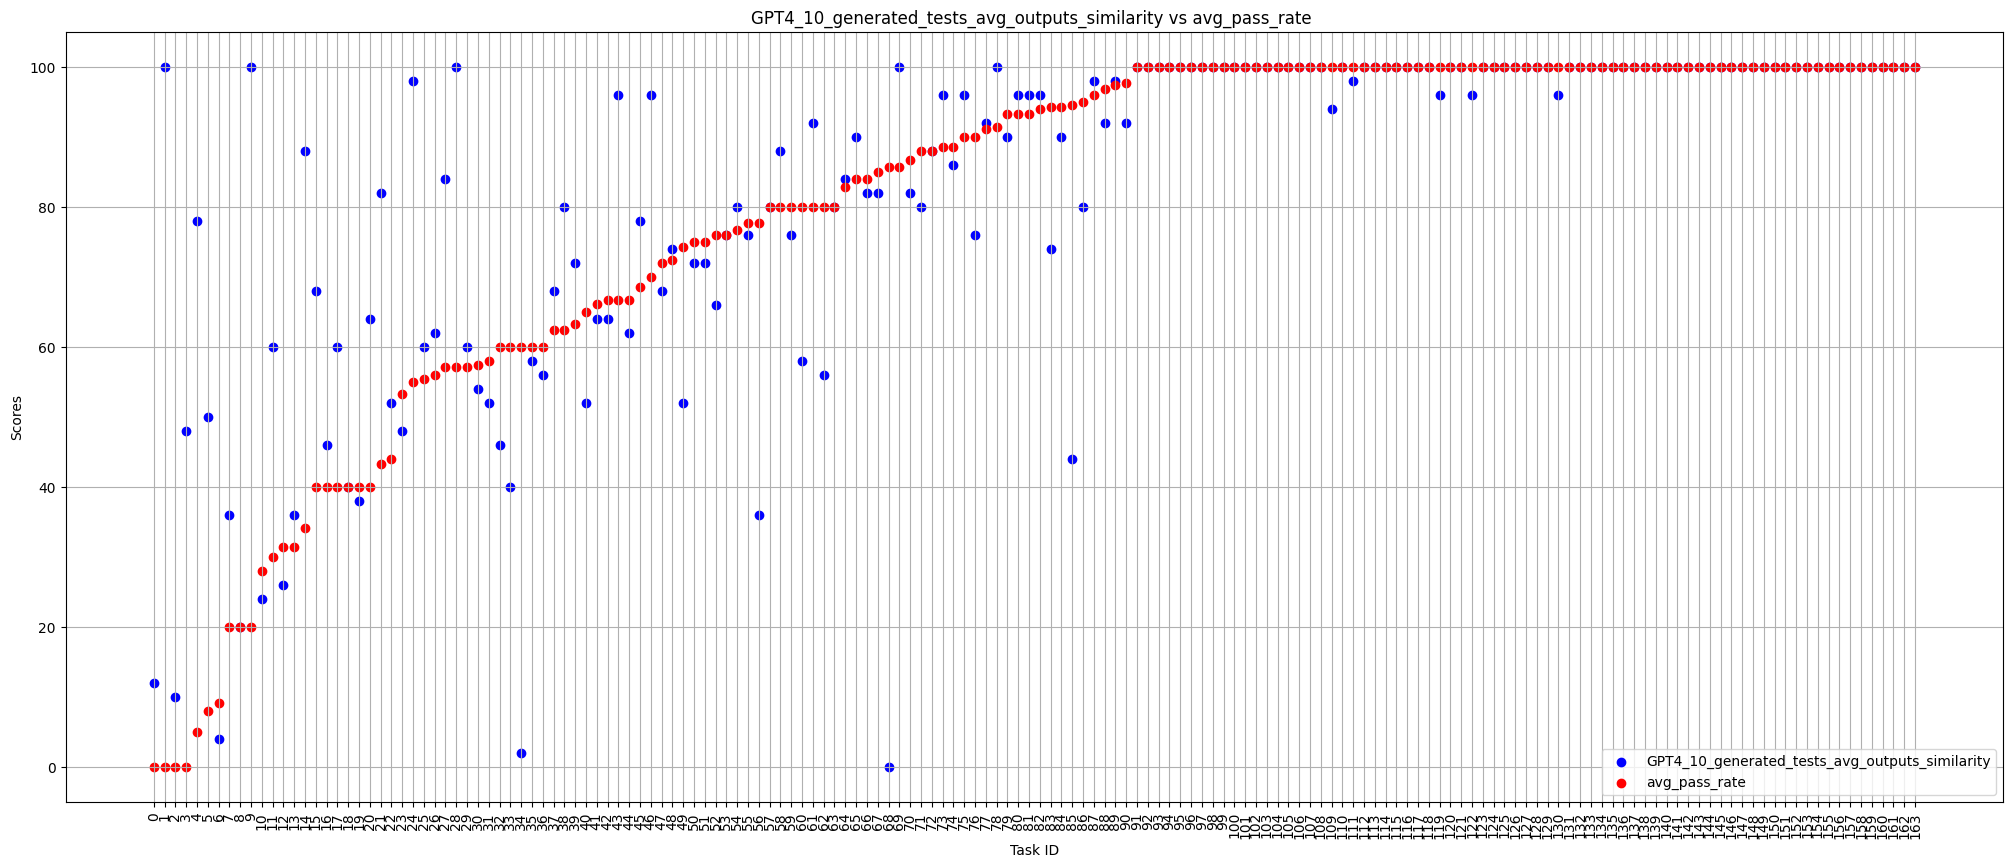

In [65]:
visualize_corr(df_with_codes.sort_values(by = 'avg_pass_rate'), 'avg_pass_rate', 'GPT4_10_generated_tests_avg_outputs_similarity')

In [66]:
df_with_codes.to_csv('test_cases_results.csv', index=False)

# Investigating Errors:

In [139]:
df = pd.read_csv('test_cases_results.csv')
temp = pd.read_json('human-eval-modified-with-tests.jsonl', lines=True)
df['test'] = temp['test']
df.head()

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output,GPT4_10_generated_tests_outputs_similarity,GPT4_10_generated_tests_avg_outputs_similarity,test
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)#lak#has_close_elem...",\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,100.0,"[['False', 'False', 'False', 'False', 'False',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))')#lak#separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,55.0,"[['', '', '', '', '', ''], ['', '', '', '', ''...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, ...",98.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75)#lak#truncate_number(10.0...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import trunc\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,100.0,"[['0.75', '0.75', '0.75', '0.75', '0.75', '0.7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])#lak#below_zero([-1...",\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\n\ndef below_zero(...,100.0,"[['False', 'False', 'False', 'False', 'False',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...",\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,100.0,"[['1.2', '1.2', '1.2', '1.2', '1.2', '1.2'], [...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."


In [143]:
# get all rows with difference between average_pass_rate and average_test_pass_rate = 70
low_df = df[abs(df['avg_pass_rate'] - df['GPT4_10_generated_tests_avg_outputs_similarity']) >= 50]
low_df

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output,GPT4_10_generated_tests_outputs_similarity,GPT4_10_generated_tests_avg_outputs_similarity,test
32,HumanEval/32,"import math\n\n\ndef poly(xs: list, x: float):...","find_zero([1, 2])#lak#find_zero([-6, 11, -6, 1...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...",34.200000,"[['', '-0.5', '-2.0', '', 'None', ''], ['', ''...","[0.4, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",88.0,\n\nMETADATA = {}\n\n\ndef check(candidate):\n...
47,HumanEval/47,"\n\ndef median(l: list):\n """"""Return median...","median([3, 1, 2, 4, 5])#lak#median([-10, 4, 6,...",\nfrom statistics import median\n\ndef median(...,\nfrom statistics import median\n\ndef median(...,\nfrom statistics import median\n\ndef median(...,\nfrom statistics import median\n\ndef median(...,\nfrom statistics import median\n\ndef median(...,\nfrom statistics import median\n\ndef median(...,0.000000,"[['', '', '', '', '', ''], ['', '', '', '', ''...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,\n\nMETADATA = {}\n\n\ndef check(candidate):\n...
83,HumanEval/83,"\ndef starts_one_ends(n):\n """"""\n Given ...",starts_one_ends(1)#lak#starts_one_ends(2)#lak#...,"\ndef starts_one_ends(n):\n """"""\n Given ...",\ndef starts_one_ends(n):\n count = 0\n ...,\ndef starts_one_ends(n):\n if n == 1:\n ...,\ndef starts_one_ends(n):\n count_start_one...,\ndef starts_one_ends(n):\n return 2 * (9 *...,\ndef starts_one_ends(n):\n from math impor...,60.000000,"[['2', '1', '1', '9.9', '1.8', '2'], ['98', '1...","[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,def check(candidate):\n total_tests_xyz = 5...
120,HumanEval/120,"\ndef maximum(arr, k):\n """"""\n Given an ...","maximum([1, 2, 3, 4], 2)#lak#maximum([5, 3, 1,...",\nfrom heapq import nlargest\n\ndef maximum(ar...,\nfrom typing import List\n\ndef maximum(arr: ...,\nfrom heapq import nlargest\n\ndef maximum(ar...,\nfrom typing import List\n\ndef maximum(arr: ...,\nfrom typing import List\n\ndef maximum(arr: ...,\nfrom heapq import nlargest\n\ndef maximum(ar...,94.545455,"[['[4, 3]', '[3, 4]', '[3, 4]', '[3, 4]', '[3,...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.4, 0.0, ...",44.0,def check(candidate):\n total_tests_xyz = 1...
122,HumanEval/122,"\ndef add_elements(arr, k):\n """"""\n Give...","add_elements([10, 20, 30, 40], 4)#lak#add_elem...",\nfrom typing import List\n\ndef add_elements(...,\nfrom typing import List\n\ndef add_elements(...,\nfrom typing import List\n\ndef add_elements(...,\nfrom typing import List\n\ndef add_elements(...,\nfrom typing import List\n\ndef add_elements(...,\nfrom typing import List\n\ndef add_elements(...,20.000000,"[['100', '100', '100', '100', '100', '100'], [...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,def check(candidate):\n total_tests_xyz = 5...
148,HumanEval/148,"\ndef bf(planet1, planet2):\n '''\n Ther...","bf(""Mercury"", ""Neptune"")#lak#bf(""Venus"", ""Mars...","\ndef bf(planet1, planet2):\n planets = [""M...","\ndef bf(planet1, planet2):\n planets = [""M...","\ndef bf(planet1, planet2):\n planets = [""M...",\nfrom typing import Tuple\n\ndef bf(planet1: ...,"\ndef bf(planet1, planet2):\n planets = [""M...","\ndef bf(planet1, planet2):\n planets = [""M...",85.714286,"[['', ""('Venus', 'Earth', 'Mars', 'Jupiter', '...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,def check(candidate):\n total_tests_xyz = 7...
163,HumanEval/163,"\ndef generate_integers(a, b):\n """"""\n G...","generate_integers(2, 8)#lak#generate_integers(...","\ndef generate_integers(a, b):\n even_digit...","\ndef generate_integers(a, b):\n return [i ...","\ndef generate_integers(a, b):\n """"""\n G...","\n

In [149]:
false_positives = []
false_negatives = []
for i, row in enumerate(low_df.iterrows()):
    if (row[1]['avg_pass_rate'] < row[1]['GPT4_10_generated_tests_avg_outputs_similarity']):
        false_positives.append(i)
    else:
        false_negatives.append(i)
print(false_positives)
print(false_negatives)

[0, 1, 4, 6]
[2, 3, 5]


In [177]:
false_negatives_df = low_df.iloc[false_negatives]
false_negatives_df

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output,GPT4_10_generated_tests_outputs_similarity,GPT4_10_generated_tests_avg_outputs_similarity,test
83,HumanEval/83,"\ndef starts_one_ends(n):\n """"""\n Given ...",starts_one_ends(1)#lak#starts_one_ends(2)#lak#...,"\ndef starts_one_ends(n):\n """"""\n Given ...",\ndef starts_one_ends(n):\n count = 0\n ...,\ndef starts_one_ends(n):\n if n == 1:\n ...,\ndef starts_one_ends(n):\n count_start_one...,\ndef starts_one_ends(n):\n return 2 * (9 *...,\ndef starts_one_ends(n):\n from math impor...,60.000000,"[['2', '1', '1', '9.9', '1.8', '2'], ['98', '1...","[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,def check(candidate):\n total_tests_xyz = 5...
120,HumanEval/120,"\ndef maximum(arr, k):\n """"""\n Given an ...","maximum([1, 2, 3, 4], 2)#lak#maximum([5, 3, 1,...",\nfrom heapq import nlargest\n\ndef maximum(ar...,\nfrom typing import List\n\ndef maximum(arr: ...,\nfrom heapq import nlargest\n\ndef maximum(ar...,\nfrom typing import List\n\ndef maximum(arr: ...,\nfrom typing import List\n\ndef maximum(arr: ...,\nfrom heapq import nlargest\n\ndef maximum(ar...,94.545455,"[['[4, 3]', '[3, 4]', '[3, 4]', '[3, 4]', '[3,...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.4, 0.0, ...",44.0,def check(candidate):\n total_tests_xyz = 1...
148,HumanEval/148,"\ndef bf(planet1, planet2):\n '''\n Ther...","bf(""Mercury"", ""Neptune"")#lak#bf(""Venus"", ""Mars...","\ndef bf(planet1, planet2):\n planets = [""M...","\ndef bf(planet1, planet2):\n planets = [""M...","\ndef bf(planet1, planet2):\n planets = [""M...",\nfrom typing import Tuple\n\ndef bf(planet1: ...,"\ndef bf(planet1, planet2):\n planets = [""M...","\ndef bf(planet1, planet2):\n planets = [""M...",85.714286,"[['', ""('Venus', 'Earth', 'Mars', 'Jupiter', '...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,def check(candidate):\n total_tests_xyz = 7...


In [194]:
prompt = false_negatives_df.iloc[0]['prompt']
codes = list(false_negatives_df.iloc[0][['code_0', 'code_1', 'code_2', 'code_3', 'code_4', 'code_5']])
tests = false_negatives_df.iloc[0]['GPT4_10_generated_tests'].split('#lak#')

print(prompt)
print('----------------')
for test in tests:
    print(test)


def starts_one_ends(n):
    """
    Given a positive integer n, return the count of the numbers of n-digit
    positive integers that start or end with 1.
    """

----------------
starts_one_ends(1)
starts_one_ends(2)
starts_one_ends(5)
starts_one_ends(10)
starts_one_ends(13)
starts_one_ends(20)
starts_one_ends(3)
starts_one_ends(7)
starts_one_ends(15)
starts_one_ends(25)


In [195]:
for code in codes:
    print(code)
    print('----------------')


def starts_one_ends(n):
    """
    Given a positive integer n, return the count of the numbers of n-digit
    positive integers that start or end with 1.
    """
    
    if n == 1:
        return 2
    else:
        start_one_count = 9 * (10 ** (n - 1))
        end_one_count = 10 ** (n - 1)
        return start_one_count + end_one_count - starts_one_ends(n-1)

----------------

def starts_one_ends(n):
    count = 0
    for i in range(10**(n-1), 10**n):
        if str(i)[0] == '1' or str(i)[-1] == '1':
            count += 1
    return count

----------------

def starts_one_ends(n):
    if n == 1:
        return 1
    else:
        count = 2 * 9 * 10**(n-2)
        return count

----------------

def starts_one_ends(n):
    count_start_one = 9 * (10 ** (n - 1))
    count_end_one = 10 ** (n - 1)
    count_both = 10 ** (n - 2)
    
    result = count_start_one + count_end_one - count_both
    
    return result


----------------

def starts_one_ends(n):
    return 2 * (9 * 10**(n-2))

In [196]:
import ast
outputs = false_negatives_df['GPT4_10_generated_tests_output'][148]

outputs = ast.literal_eval(outputs)

for sublist in outputs:
    print(sublist)

['', "('Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus')", "('Earth', 'Jupiter', 'Mars', 'Saturn', 'Uranus', 'Venus')", "('Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus')", "('Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus')", "('Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus')"]
['', "('Earth',)", '()', "('Earth',)", "('Earth',)", "('Earth',)"]
['', "('Mars',)", "('Mars',)", "('Mars',)", "('Mars',)", "('Mars',)"]
['', '()', '()', '()', '()', '()']
['', "('Saturn', 'Jupiter', 'Mars', 'Earth', 'Venus')", "('Earth', 'Jupiter', 'Mars', 'Saturn', 'Venus')", "('Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn')", "('Saturn', 'Jupiter', 'Mars', 'Earth', 'Venus')", "('Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn')"]
['', "('Uranus', 'Saturn')", "('Saturn', 'Uranus')", "('Saturn', 'Uranus')", "('Uranus', 'Saturn')", "('Saturn', 'Uranus')"]
['', "('Earth',)", '()', "('Earth',)", "('Earth',)", "('Earth',)"]
['', "('Mars', 'Jupiter', 'Saturn')", "('Jupiter', 'Mars', 'Saturn

In [197]:
test_prepared = f"print({tests[0]})"
check_program = f"{codes[0]}\n{test_prepared}"
print(check_program, '\n----------------\n')
res, err = run_tests(check_program, test_number = 1, code_number = 0 ,task_id = 122, timeout=40 )
print(res)
print(50*"-")
print(err)


def starts_one_ends(n):
    """
    Given a positive integer n, return the count of the numbers of n-digit
    positive integers that start or end with 1.
    """
    
    if n == 1:
        return 2
    else:
        start_one_count = 9 * (10 ** (n - 1))
        end_one_count = 10 ** (n - 1)
        return start_one_count + end_one_count - starts_one_ends(n-1)

print(starts_one_ends(1)) 
----------------

2
--------------------------------------------------



In [130]:
# SAMPLE 109
df1 = pd.read_csv('first results.csv')
df2 = pd.read_csv('test_cases_results.csv')
temp = pd.read_json('human-eval-modified-with-tests.jsonl', lines=True)
df1['test'], df2['test'] = temp['test'], temp['test']

In [131]:
df1 = df1[df1['average_pass_rate'] > 95]
df2 = df2[df2['avg_pass_rate'] > 95]
df2

,task_id,prompt,GPT4_10_generated_tests,code_0,code_1,code_2,code_3,code_4,code_5,avg_pass_rate,GPT4_10_generated_tests_output,GPT4_10_generated_tests_outputs_similarity,GPT4_10_generated_tests_avg_outputs_similarity,test
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)#lak#has_close_elem...",\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,100.0,"[['False', 'False', 'False', 'False', 'False',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75)#lak#truncate_number(10.0...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import trunc\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,100.0,"[['0.75', '0.75', '0.75', '0.75', '0.75', '0.7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])#lak#below_zero([-1...",\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\n\ndef below_zero(...,\nfrom typing import List\n\n\ndef below_zero(...,100.0,"[['False', 'False', 'False', 'False', 'False',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...",\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,100.0,"[['1.2', '1.2', '1.2', '1.2', '1.2', '1.2'], [...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
7,HumanEval/7,from typing import List\n\n\ndef filter_by_sub...,"filter_by_substring(['hello', 'world'], 'o')#l...",\nfrom typing import List\n\ndef filter_by_sub...,\nfrom typing import List\n\ndef filter_by_sub...,\nfrom typing import List\n\ndef filter_by_sub...,\nfrom typing import List\n\ndef filter_by_sub...,\nfrom typing import List\n\n\ndef filter_by_s...,\nfrom typing import List\n\n\ndef filter_by_s...,100.0,"[[""['hello', 'world']"", ""['hello', 'world']"", ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,HumanEval/152,"\ndef compare(game,guess):\n """"""I think we ...","compare([1, 2, 3, 4, 5, 1], [1, 2, 3, 4, 2, -2...",\nfrom typing import List\n\ndef compare(game:...,\nfrom typing import List\n\ndef compare(game:...,\nfrom typing import List\n\ndef compare(game:...,\nfrom typing import List\n\ndef compare(game:...,\nfrom typing import List\n\ndef compare(game:...,\nfrom typing import List\n\ndef compare(game:...,100.0,"[['[0, 0, 0, 0, 3, 3]', '[0, 0, 0, 0, 3, 3]', ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,def check(candidate):\n total_tests_xyz = 4...
155,HumanEval/155,"\ndef even_odd_count(num):\n """"""Given an in...",even_odd_count(0)#lak#even_odd_count(123456789...,"\ndef even_odd_count(num):\n """"""Given an in...",\ndef even_odd_count(num):\n num_str = str(...,\ndef even_odd_count(n

In [133]:
not_equals_df = df2[df1['average_tests_pass_rate'] != df2['GPT4_10_generated_tests_avg_outputs_similarity']]
not_equals_df = pd.merge(not_equals_df, df1, on='task_id', how='inner')
not_equals_df

,task_id,prompt_x,GPT4_10_generated_tests,code_0_x,code_1_x,code_2_x,code_3_x,code_4_x,code_5_x,avg_pass_rate,...,test_3_pass_rate,test_4_pass_rate,test_5_pass_rate,test_6_pass_rate,test_7_pass_rate,test_8_pass_rate,test_9_pass_rate,test_10_pass_rate,average_tests_pass_rate,test_y
0,HumanEval/78,"\ndef hex_key(num):\n """"""You have been task...","hex_key(""AB"")#lak#hex_key(""1077E"")#lak#hex_key...",\ndef hex_key(num):\n def is_prime(n):\n ...,\nimport sympy\n\ndef hex_key(num):\n prime...,\nfrom sympy import isprime\n\ndef hex_key(num...,\nfrom sympy import isprime\n\ndef hex_key(num...,\nimport math\n\ndef hex_key(num):\n def is...,\nimport re\nfrom sympy import isprime\n\ndef ...,100.0,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,20.0,def check(candidate):\n total_tests_xyz = 7...
1,HumanEval/94,"\n\ndef skjkasdkd(lst):\n """"""You are given ...","skjkasdkd([0,3,2,1,3,5,7,4,5,5,5,2,181,32,4,32...",\nimport math\n\ndef skjkasdkd(lst):\n def ...,\nimport math\n\ndef skjkasdkd(lst):\n def ...,\nimport sympy\n\ndef skjkasdkd(lst):\n pri...,\nimport math\n\ndef skjkasdkd(lst):\n def ...,\nimport math\n\ndef skjkasdkd(lst):\n def ...,\nimport sympy\n\ndef skjkasdkd(lst):\n def...,100.0,...,0.6,0.6,0.6,0.6,1.0,1.0,1.0,1.0,76.0,def check(candidate):\n total_tests_xyz = 9...
2,HumanEval/143,"\ndef words_in_sentence(sentence):\n """"""\n ...","words_in_sentence(""This is a test"")#lak#words_...",\nfrom sympy import isprime\n\ndef words_in_se...,\nfrom sympy import isprime\n\ndef words_in_se...,\nimport sympy\n\ndef words_in_sentence(senten...,\nfrom sympy import isprime\n\ndef words_in_se...,\nimport sympy\n\ndef words_in_sentence(senten...,\nimport math\n\ndef is_prime(n):\n if n < ...,100.0,...,1.0,0.8,0.8,0.8,0.8,0.8,1.0,0.8,84.0,def check(candidate):\n total_tests_xyz = 7...


In [52]:
"""
[important case]: base is wrong i.e.:"", rest wrong but similar to base -> false positive "possibly no solution for this"
      depends on type cause if str it could be the case that the correct soln is an empty str
      
[important case]: base is correct, rest correct but different from base -> false negative "possibly no solution for this as there is no way to know if order matters or not"
      invistigate exact matches limitation, i.e.: [1,2,3] and [1,3,2] won't be similar because they get compared as a string

case: base is correct, rest correct and similar to base -> true positive

case: base is wrong, rest wrong but different from base -> true negative
case: base is wrong, rest correct but different from base -> true negative
"""

code =  df.iloc[0]["code_0"]
test = df.iloc[0]["test_1"]
test_prepared = f"print({test})"
test_prepared = test_prepared + "\n" + f"print(type({test}))"
check_program = f"{code}\n{test_prepared}"
res_vec = run_tests(check_program, test_number = 1, code_number = 0 ,task_id = 0, timeout=40)

res.split("\r\n")[0]
res_type = res.split("\r\n")[1]
res_type = res_type.split(" ")[1]

AttributeError: 'list' object has no attribute 'split'

FP
[Problem]sample #47, which is 2nd in false positives, returns empty strings because of a valid recursion error due to misnaming the function in the solution
    [sol] isolate any results with errors

[Problem]sample #122, which is 3rd in false positives, is a true false positive because chatgpt returns the same incorrect fn for the 6 codes so they are all wrong in the same way
    [sol]try a better model than 3.5

[Problem]sample #32, which is 1st in false positives, returns "" with tests 3-10 because its check program has a syntax error as the tests returned by chatgpt has comments so the ) closes after the comment and the ) for the print () is never closed. Code_0 in that sample returns "" too because of a type error as it uses the helper function in a wrong way. Code_1 with test 2 returns "" because of ValueError raised by the code 
    [sol]try a better model than 3.5
    [sol_to_implement_now]optimize prompt and watch stderr

FN
[Problem]sample #120, which is 2nd in false negatives, is an accurate false negative because the base code is wrong but the samples are correct
    the sample codes aren't all correct; see test 8 which should return []
    [sol]try better model, or don't solve

[Problem]sample #148, which is 3rd in false negatives, has base code with ValueError and rest of codes correct. base code also includes examples with print statements that might cause errors
    [sol]try a better model than 3.5

[Note]sample #47, which is 2nd in false positives, has all of its 6 codes identical because it's too simple
[Note]sample #32, which is 1st in false positives, has code_4 returning nothing so what should we do for no output functions